<a href="https://colab.research.google.com/github/rwothani/Rachel_myrepo/blob/master/Matrix_Based_RGB_Drawing_System_%E2%80%93_Advanced_Prototype.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

install and import libraries

In [1]:
!pip install ipycanvas
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider, Dropdown, Button, HBox, VBox, ColorPicker
from ipycanvas import Canvas
from IPython.display import display
import os
import glob


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.2/143.2 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 26.5 MB/s eta 0:00:00


folder and counter setup

In [2]:
save_folder = "matrix_images_advanced"
os.makedirs(save_folder, exist_ok=True)
image_counter = 1  # global counter for saved filenames


RGB matrix initialization

In [3]:
height, width = 256, 256  # matrix size
current_matrix = np.zeros((height, width, 3), dtype=np.uint8)  # blank RGB matrix


display and save function

In [4]:
def display_and_save_rgb(matrix, description="Image"):
    global image_counter
    img = Image.fromarray(matrix, mode='RGB')
    plt.imshow(matrix)
    plt.axis('off')
    plt.show()

    filename = f"{description}_{image_counter}.png"
    filepath = os.path.join(save_folder, filename)
    img.save(filepath)
    print(f"Image saved as {filepath}")

    image_counter += 1


pattern templates

In [5]:
def random_pattern(height, width):
    return np.random.randint(0, 256, (height, width, 3), dtype=np.uint8)

def gradient_pattern(height, width):
    mat = np.zeros((height, width, 3), dtype=np.uint8)
    for i in range(height):
        for j in range(width):
            mat[i,j] = [int(j/width*255), int(i/height*255), int((i+j)/(height+width)*255)]
    return mat

def checkerboard_pattern(height, width, block_size=16):
    mat = np.zeros((height, width, 3), dtype=np.uint8)
    for i in range(height):
        for j in range(width):
            color = 0 if (i//block_size + j//block_size) %2 ==0 else 255
            mat[i,j] = [color,color,color]
    return mat

def radial_gradient(height, width, center=None):
    if center is None:
        center = (height//2, width//2)
    mat = np.zeros((height, width, 3), dtype=np.uint8)
    for i in range(height):
        for j in range(width):
            dist = ((i - center[0])**2 + (j - center[1])**2)**0.5
            val = int((dist / max(height, width)) * 255)
            mat[i,j] = [val,val,val]
    return mat

def sine_wave_pattern(height, width):
    mat = np.zeros((height, width, 3), dtype=np.uint8)
    for i in range(height):
        for j in range(width):
            val = int((np.sin(j/10) + 1) * 127)
            mat[i,j] = [val, val, 255-val]
    return mat


bulk editing tools

In [6]:
def fill_rectangle(matrix, x_start, y_start, width_rect, height_rect, color):
    x_end = min(x_start + width_rect, matrix.shape[0])
    y_end = min(y_start + height_rect, matrix.shape[1])
    matrix[x_start:x_end, y_start:y_end] = color
    return matrix

def draw_horizontal_line(matrix, row, color):
    matrix[row, :] = color
    return matrix

def draw_vertical_line(matrix, col, color):
    matrix[:, col] = color
    return matrix

def draw_circle(matrix, center_x, center_y, radius, color):
    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            if (i - center_x)**2 + (j - center_y)**2 <= radius**2:
                matrix[i, j] = color
    return matrix


pixel editing with palette and brush size

In [7]:
canvas = Canvas(width=width, height=height)
display(canvas)

# Color Picker Widget
color_picker = ColorPicker(
    concise=False,
    description='Pick Color:',
    value='#ff0000',
    disabled=False
)
display(color_picker)

# Brush size slider
brush_size_slider = IntSlider(
    value=1,
    min=1,
    max=10,
    step=1,
    description='Brush Size:'
)
display(brush_size_slider)

# Undo/Redo setup
matrix_history = []
redo_history = []

def save_history():
    matrix_history.append(current_matrix.copy())
    if len(matrix_history) > 20:
        matrix_history.pop(0)

def undo_action(b):
    global current_matrix
    if matrix_history:
        redo_history.append(current_matrix.copy())
        current_matrix[:] = matrix_history.pop()
        display_and_save_rgb(current_matrix, description="undo")

def redo_action(b):
    global current_matrix
    if redo_history:
        matrix_history.append(current_matrix.copy())
        current_matrix[:] = redo_history.pop()
        display_and_save_rgb(current_matrix, description="redo")

undo_btn = Button(description="Undo")
redo_btn = Button(description="Redo")
undo_btn.on_click(undo_action)
redo_btn.on_click(redo_action)
display(HBox([undo_btn, redo_btn]))

# Painting function with brush size and color
def paint_with_brush(x, y):
    save_history()
    if 0 <= x < width and 0 <= y < height:
        hex_color = color_picker.value.lstrip('#')
        rgb_color = [int(hex_color[i:i+2],16) for i in (0,2,4)]

        size = brush_size_slider.value
        x_start = max(x - size//2, 0)
        x_end = min(x + size//2 + 1, width)
        y_start = max(y - size//2, 0)
        y_end = min(y + size//2 + 1, height)

        current_matrix[y_start:y_end, x_start:x_end] = rgb_color

        canvas.fill_style = color_picker.value
        canvas.fill_rect(x_start, y_start, x_end-x_start, y_end-y_start)

        display_and_save_rgb(current_matrix, description="canvas_brush")

canvas.on_mouse_down(paint_with_brush)
canvas.on_mouse_move(paint_with_brush)


Canvas(height=256, width=256)

ColorPicker(value='#ff0000', description='Pick Color:')

IntSlider(value=1, description='Brush Size:', max=10, min=1)

In [13]:
from google.colab import output
output.enable_custom_widget_manager()

Support for third party widgets will remain active for the duration of the session. To disable support:

In [14]:
from google.colab import output
output.disable_custom_widget_manager()

pattern drop down for quick generation

In [15]:
def generate_pattern(pattern_type='Random'):
    global current_matrix
    if pattern_type=='Random':
        current_matrix = random_pattern(height, width)
    elif pattern_type=='Gradient':
        current_matrix = gradient_pattern(height, width)
    elif pattern_type=='Checkerboard':
        current_matrix = checkerboard_pattern(height, width)
    elif pattern_type=='Radial Gradient':
        current_matrix = radial_gradient(height, width)
    elif pattern_type=='Sine Wave':
        current_matrix = sine_wave_pattern(height, width)

    display_and_save_rgb(current_matrix, description=pattern_type)

interact(generate_pattern,
         pattern_type=Dropdown(options=['Random','Gradient','Checkerboard','Radial Gradient','Sine Wave'], description='Pattern:'));


interactive(children=(Dropdown(description='Pattern:', options=('Random', 'Gradient', 'Checkerboard', 'Radial …

quick bulk edit buttons

Button(description='Red Rectangle', style=ButtonStyle())

/tmp/ipython-input-2293716285.py:3: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  img = Image.fromarray(matrix, mode='RGB')


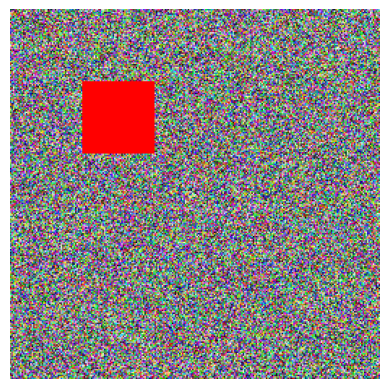

Image saved as matrix_images_advanced/red_rect_3.png


/tmp/ipython-input-2293716285.py:3: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  img = Image.fromarray(matrix, mode='RGB')


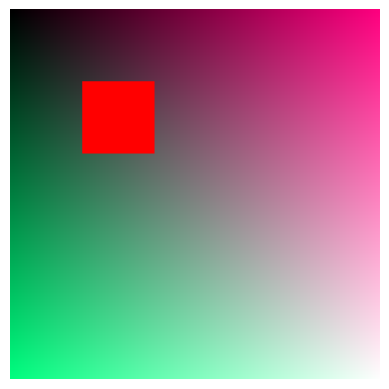

Image saved as matrix_images_advanced/red_rect_5.png


/tmp/ipython-input-2293716285.py:3: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  img = Image.fromarray(matrix, mode='RGB')


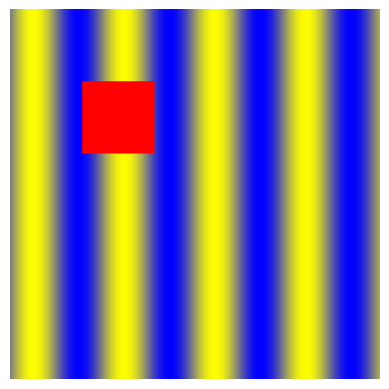

Image saved as matrix_images_advanced/red_rect_7.png


In [11]:
btn_red_rect = Button(description="Red Rectangle")
def add_red_rect(b):
    global current_matrix
    fill_rectangle(current_matrix, 50,50,50,50,[255,0,0])
    display_and_save_rgb(current_matrix, description="red_rect")
btn_red_rect.on_click(add_red_rect)
display(btn_red_rect)


export gif of drwaing process

In [17]:
def export_gif(folder=save_folder, output_name="drawing_process.gif", duration=500):
    files = sorted(glob.glob(f"{folder}/*.png"))
    images = [Image.open(file) for file in files]

    if images:
        images[0].save(
            output_name,
            save_all=True,
            append_images=images[1:],
            duration=duration,
            loop=0
        )
        print(f"GIF saved as {output_name}")
    else:
        print("No images found in folder to create GIF.")

# Example usage
export_gif(duration=400)


GIF saved as drawing_process.gif
